# Visual Search with Object Localization

This is reference implementation of an object localization model that can be used in visual search. 

### Use Case
We want to build a visual search service that receives an image which may contain several objects and searches for nearest neighbors for each object in a collection of images. For example, a fashion retailer might want to build shop-the-look service that allows a user to upload a picture of a model which wears several garments and get visually similar products from the catalog for each garment.   

### Prototype: Approach and Data
We train U-Net [1] on street fashion images to localize clothes. The segmentation masks then can be used to extract the relevant parts of the image and search for similar products. The implementation is based on [2]. We use `clothing-co-parsing` dataset (see `datasets.md` for details).

### Usage and Productization
A complete visual search solution can be created by combing this prototype with a visual search workflow where the images of individual garments are indexed, and then searched using distances in the embedding space.

### References
1. Olaf Ronneberger, Philipp Fischer, Thomas Brox -- U-Net: Convolutional Networks for Biomedical Image Segmentation, 2015
2. https://github.com/IzPerfect/Clothing-Segmentation

In [1]:
#
# Imports and settings
#
import cv2
import os
import platform

import numpy as np
import scipy.io as spio
import matplotlib.pyplot as plt
plt.rcParams.update({'pdf.fonttype': 'truetype'})

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D 
from tensorflow.keras.layers import MaxPooling2D, Input, Concatenate, Conv2DTranspose
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split

print(f'Tensorflow {tf.__version__}')
print(f'Python {platform.python_version()}')

Tensorflow 2.4.1
Python 3.8.5


# Load Images and Segmentation Masks

Found 2098 images, 1004 annotations


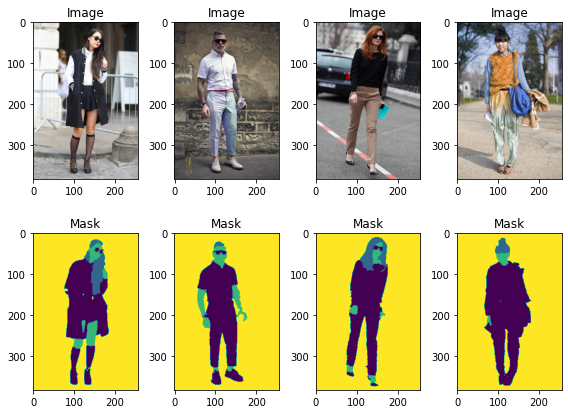

In [43]:
base_path = 'clothing-co-parsing-master'
image_path = base_path + '/photos/'
label_path = base_path + '/annotations/pixel-level/'
valid_exts = [".jpg", ".mat"] 
image_list = [i for i in sorted(os.listdir(image_path)) if os.path.splitext(i)[1].lower() in valid_exts]
label_list = [i for i in sorted(os.listdir(label_path)) if os.path.splitext(i)[1].lower() in valid_exts]
print(f'Found {len(image_list)} images, {len(label_list)} annotations')

x_list = []
img_h, img_w = 384, 256
for image_id in image_list:
    img = cv2.imread(image_path + image_id, 1)
    img = cv2.resize(img, dsize=(img_w, img_h))
    x_list.append(img)

# Reduce the number of classes
# We use only 4 classes (background, skin, hair, and clothes)
def map_label(x):
    if x == 0:
        return 0 # background
    if x == 41:
        return 1 # skin
    if x == 19:
        return 2 # hair
    return 3     # clothes 

map_label_v = np.vectorize(map_label)

mask_list = []
for label_id in label_list:
    mask_ex = spio.loadmat(label_path + label_id)['groundtruth']
    mask_ex = cv2.resize(mask_ex, dsize=(img_w, img_h), interpolation= cv2.INTER_NEAREST)
    mask_ex = map_label_v(mask_ex)
    mask_list.append(mask_ex)
    
idxs = [0, 20, 100, 200]
fig, ax = plt.subplots(2, len(idxs), figsize=(2*len(idxs), 6))
for i, idx in enumerate(idxs):
    ax[0, i].imshow(cv2.cvtColor(x_list[idx], cv2.COLOR_BGR2RGB))
    ax[0, i].set_title('Image')
    ax[1, i].imshow(-mask_list[idx])
    ax[1, i].set_title('Mask')
plt.tight_layout()

plt.savefig('data.pdf')

# Prepare Training and Test Datasets

In [3]:
x = np.array(x_list)
y = np.array(mask_list).reshape([-1, img_h, img_w, 1])
y = to_categorical(y) # one-hot class encoding
print(f'x: {x.shape}, y: {y.shape}')

train_test_ratio = 0.75
x_train, x_test, y_train, y_test = train_test_split(x[0:len(y)], y, train_size=train_test_ratio)
print(f'x_train: {x_train.shape}, x_test: {x_test.shape}')
print(f'y_train: {y_train.shape}, y_test: {y_test.shape}')

x: (2098, 384, 256, 3), y: (1004, 384, 256, 4)
x_train: (753, 384, 256, 3), x_test: (251, 384, 256, 3)
y_train: (753, 384, 256, 4), y_test: (251, 384, 256, 4)


# Specify and Train the UNet Model

In [4]:
class UNet(object):
    def __init__(self, 
                 img_shape, 
                 num_of_class, 
                 actf = 'relu',
                 learning_rate = 0.001,  
                 drop_rate = 0.5, 
                 do_batch_norm = False, 
                 do_drop = False):
        self.learning_rate = learning_rate
        self.actf = actf
        self.img_shape = img_shape
        self.num_of_class = num_of_class
        self.drop_rate = drop_rate
        self.do_batch_norm = do_batch_norm
        self.do_drop = do_drop

        self.model = self.build_model()

    # encoding block(conv - conv - pool)
    def enc_conv_block(self, inputs, feature_maps, filter_size = (3, 3),
                           conv_strides = 1, pooling_filter_size = (2, 2), pooling_strides = (2, 2)):
        conv1 = Conv2D(feature_maps , filter_size , activation = self.actf, strides = conv_strides,
                           padding = 'same', kernel_initializer = 'he_normal')(inputs)
        conv2 = Conv2D(feature_maps , filter_size , activation = self.actf, strides = conv_strides,
                           padding = 'same', kernel_initializer = 'he_normal')(conv1)
        pool = MaxPooling2D(pooling_filter_size, strides = pooling_strides)(conv2)

        return pool, conv2

    # decoding block(concat - upconv - upconv)
    def dec_conv_block(self, inputs, merge_inputs, feature_maps, filter_size = (3, 3), conv_strides = 1,
                           up_conv_strides = (2, 2)):

        merge = Concatenate(axis = 3)([Conv2DTranspose(feature_maps, filter_size,
                                                       activation = self.actf, strides = up_conv_strides, kernel_initializer = 'he_normal',
                                                       padding = 'same')(inputs), merge_inputs])

        conv1 = Conv2D(feature_maps , filter_size , activation = self.actf, strides = conv_strides,
                           padding = 'same', kernel_initializer = 'he_normal')(merge)
        conv2 = Conv2D(feature_maps , filter_size , activation = self.actf, strides = conv_strides,
                           padding = 'same', kernel_initializer = 'he_normal')(conv1)

        return conv2

    # encoder
    def encoding_path(self, inputs):

        enc_conv1, concat1 = self.enc_conv_block(inputs, 64)
        enc_conv2, concat2 = self.enc_conv_block(enc_conv1, 128)
        enc_conv3, concat3 = self.enc_conv_block(enc_conv2, 256)
        enc_conv4, concat4 = self.enc_conv_block(enc_conv3, 512)

        return concat1, concat2, concat3, concat4, enc_conv4

    # decoder
    def decoding_path(self, dec_inputs, concat1, concat2, concat3, concat4):

        dec_conv1 = self.dec_conv_block(dec_inputs, concat4, 512)
        dec_conv2 = self.dec_conv_block(dec_conv1, concat3, 256)
        dec_conv3 = self.dec_conv_block(dec_conv2, concat2, 128)
        dec_conv4 = self.dec_conv_block(dec_conv3, concat1, 64)

        return dec_conv4
    
    # build network
    def build_model(self):
        inputs = Input(self.img_shape)

        # Contracting path
        concat1, concat2, concat3, concat4, enc_path = self.encoding_path(inputs)

        # middle path
        mid_path1 = Conv2D(1024, (3,3), activation = self.actf, padding = 'same', kernel_initializer = 'he_normal')(enc_path)
        mid_path1 = Dropout(self.drop_rate)(mid_path1)
        mid_path2 = Conv2D(1024, (3,3), activation = self.actf, padding = 'same', kernel_initializer = 'he_normal')(mid_path1)
        mid_path2 = Dropout(self.drop_rate)(mid_path2)

        # Expanding path
        dec_path = self.decoding_path(mid_path2, concat1, concat2, concat3, concat4)
        segmented = Conv2D(self.num_of_class, (1,1), activation = self.actf, padding = 'same', kernel_initializer = 'he_normal')(dec_path)
        segmented = Activation('softmax')(segmented)

        model = Model(inputs = inputs, outputs = segmented)
        model.compile(optimizer = Adam(learning_rate = self.learning_rate),
                          loss = 'categorical_crossentropy', metrics = ['accuracy'])

        return model

    # train model
    def train(self, X_train, Y_train, epoch = 10, batch_size = 32, val_split = 0.2, shuffle = True):

        self.history = self.model.fit(X_train, Y_train, validation_split = val_split,
                                          epochs = epoch, batch_size = batch_size, shuffle =  shuffle)
        return self.history

    # train with data augmentation
    def train_generator(self, x_train, y_train, x_test, y_test, epoch = 10, batch_size = 32, val_split = 0.2, min_lr = 1e-06):

        train_datagen = ImageDataGenerator(
            rescale=1./255,
            brightness_range=[0.7, 1.3]
        )

        val_datagen = ImageDataGenerator(
            rescale=1./255
        )

        train_gen = train_datagen.flow(
            x_train,
            y_train,
            batch_size = batch_size,
            shuffle=True
        )

        val_gen = val_datagen.flow(
            x_test,
            y_test,
            batch_size = batch_size,
            shuffle=False
        )

        reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.2, patience = 5, verbose = 1, min_lr = min_lr)

        self.history = self.model.fit( train_gen,
                                       validation_data=val_gen,
                                       epochs=epoch,
                                       callbacks=[reduce_lr])
        return self.history

In [ ]:
model = UNet(img_shape = x_train[0].shape, num_of_class = 4, learning_rate = 1e-3)
history = model.train_generator(x_train, y_train, 
                                x_test, y_test, 
                                epoch = 20,
                                batch_size = 8)

# Evaluate the Model

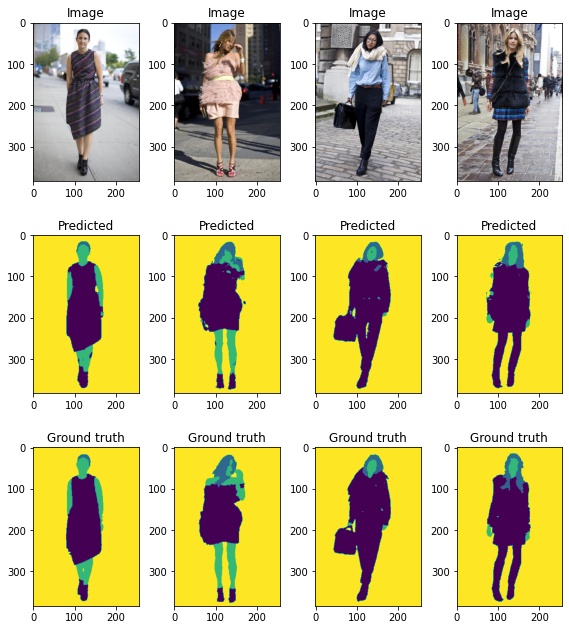

In [44]:
idxs = [10, 20, 110, 200]
fig, ax = plt.subplots(3, len(idxs), figsize=(2*len(idxs), 3*3))
for i, idx in enumerate(idxs):
    ax[0, i].imshow(cv2.cvtColor(x_test[idx, :], cv2.COLOR_BGR2RGB))
    ax[0, i].set_title('Image')

    test_img = model.model.predict(x_test[idx, :].reshape([1, img_h, img_w, 3])/255.)
    argm = np.argmax(np.array(test_img), axis=3)
    ax[1, i].imshow( -np.squeeze(argm) )
    ax[1, i].set_title('Predicted')
    
    ax[2, i].imshow( -np.argmax(y_test[idx, :], axis=2) )
    ax[2, i].set_title('Ground truth')
    
plt.tight_layout()